<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [プリント基板の電子部品検出 Nishika株式会社](https://competition.nishika.com/competitions/kiban/summary)

## Build Environment

/content/drive/MyDrive/PCB_Detect/: Working directory  
┣ 01_input: A directory includes input data in competition  
┃ ┣ train_imgs.zip: A zip file including train images    
┃ ┣ test_imgs.zip: A zip file including test images  
┃ ┣ train.csv:  A csv file in which table data written for training.   
┃ ┣ test.csv: A csv file in which table data written for test.  
┃ ┗ sample_submission.csv: A csv file is sample for submission.  
┣ 03_code: A directory for main code.
┣ 04_model: A directory for model.  
┗ 05_submission: A directory for submission data file.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
TEMP_DIR = "./temp"
INPUT_DIR:str = "/content/drive/MyDrive/PCB_Detect/01_input"
#TRAIN_DIR:str = INPUT_DIR + "/train_data"
#TEST_DIR:str = INPUT_DIR + "/test_data"
#ANALYSIS_DIR:str = "/content/drive/MyDrive/Human_Activity_Recognition_with_Smartphones/03_code-analysis"
MODEL_DIR:str = "/content/drive/MyDrive/PCB_Detect//04_model"
SUBMISSION_DIR:str = '/content/drive/MyDrive/PCB_Detect/05_submission'
CHECKPOINT_PATH:str = MODEL_DIR

In [3]:
import os, shutil, glob, zipfile

if not os.path.isdir('./train_imgs') and  not os.path.isdir('./test_imgs'):
  # Copy ZIP files including images, and Unzip them.
  !cp -r "/content/drive/MyDrive/PCB_Detect/01_input/train_imgs.zip" ./
  !cp -r "/content/drive/MyDrive/PCB_Detect/01_input/test_imgs.zip" ./
  shutil.unpack_archive('train_imgs.zip', './')
  shutil.unpack_archive('test_imgs.zip', './')

## Define Rle decoding with tensorflow

In [4]:
import tensorflow as tf

def rle_decode_tf(mask_rle, shape):
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    # Reshape into mask
    return tf.reshape(mask_flat, shape)

## Confirm Data

In [29]:
import pandas as pd
train = pd.read_csv(INPUT_DIR + "/train.csv")
train.head()

,Instance ID,image,filename_index,height,width,Vertices,rle
0,0,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[698, 4511], [698, 4436], [700, 4434], [702,...",30062961 47 30069742 50 30076523 53 30083305 5...
1,1,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[241, 4507], [240, 4508], [240, 4535], [239,...",30571223 31 30578005 32 30584788 32 30591571 3...
2,2,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[545, 3351], [547, 3351], [548, 3349], [548,...",22506489 15 22513271 42 22520054 55 22526837 5...
3,3,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[281, 3410], [329, 3409], [331, 3408], [332,...",22913254 52 22920035 55 22926817 57 22933600 5...
4,4,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[392, 3562], [384, 3563], [383, 3562], [383,...",23415311 59 23422094 60 23428877 60 23435660 6...


In [31]:
pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


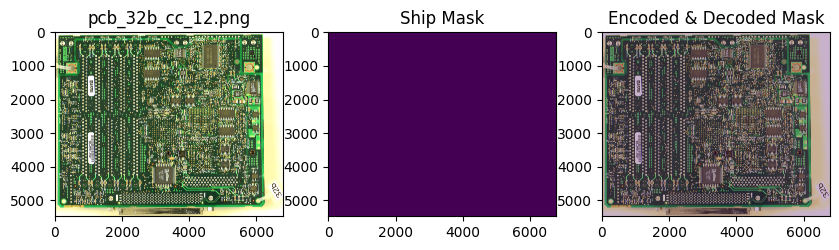

pcb_32b_cc_12.png  Check Decoding->Encoding RLE_0: 1391 -> RLE_1: 0


In [43]:
# ref:https://www.kaggle.com/code/samlin001/mask-r-cnn-ship-detection-minimum-viable-model-1

import matplotlib.pyplot as plt # plot & image processing
from skimage.morphology import label
from skimage.io import imread

# ref: https://www.kaggle.com/kmader/baseline-u-net-model-part-1
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    '''
    # reshape to 1d array
    pixels = img.T.flatten() # Needed to align to RLE direction
    # pads the head & the tail with 0 & converts to ndarray
    pixels = np.concatenate([[0], pixels, [0]])
    # gets all start(0->1) & end(1->0) positions
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    # transforms end positions to lengths
    runs[1::2] -= runs[::2]
    # converts to the string formated: '[s0] [l0] [s1] [l1]...'
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    shape: (height,width) of array to return
    Returns numpy array according to the shape, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    # gets starts & lengths 1d arrays
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    # gets ends 1d array
    ends = starts + lengths
    # creates blank mask image 1d array
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    # sets mark pixles
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # reshape as a 2d mask image
    ##return img.reshape(shape).T  # Needed to align to RLE direction
    return img.reshape(shape)

def masks_as_image(in_mask_list, shape):
    '''Take the individual ship masks and create a single mask array for all ships
    in_mask_list: pd Series: [idx0] [RLE string0]...
    Returns numpy array as (shape.h, sahpe.w, 1)
    '''
    all_masks = np.zeros(shape, dtype = np.int16)
    # if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask, shape)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path):
    '''Show image, ship mask, and encoded/decoded result
    '''
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    # image
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)

    ###############################
    height:int = train['height'][0]
    width:int = train['width'][0]
    rle = train['rle'][0]
    shape = [height, width]
    ###############################

    # input mask
    #rle_1 = train.query('image=="{}"'.format(image_id))['rle']
    rle_1 = rle
    img_1 = masks_as_image(rle_1, shape)
    # takes 2d array (shape.h, sahpe.w)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')

    # encode & decode mask
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2, shape)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

# inspects a few example
path = './train_imgs/'
shows_decode_encode(train['image'][0], path)
#shows_decode_encode('00003e153.jpg')
#print('It could be different when there is no mask.')
#shows_decode_encode('00021ddc3.jpg')
#print('It could be different when there are masks overlapped.')

In [6]:
height:int = train['height'][0]
width:int = train['width'][0]
rle = train['rle'][0]
shape = [height, width]

rle_decode_tf(rle,shape)

<tf.Tensor: shape=(5474, 6783), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [44]:
import numpy as np
def parse_img(df, new_size=[128,128]):

  height:int = df['height'][0]
  width:int = df['width'][0]
  rle = df['rle'][0]
  shape = [height, width]

  # Image
  file_path = './train_imgs/'+df['image'][0]
  img_content = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img_content)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img,new_size)

  # Mask
  ##file_id = tf.strings.split(file_path,'/')[-1]
  ##objects = [rle_decode(m) for m in df2[train['filename_index']==file_id]]
  objects = rle_decode_tf(rle,shape)
  mask = np.sum(objects,axis=0)
  mask = np.expand_dims(mask,3)   # Force mask to have 3 channels, necessary for resize step
  mask = tf.image.convert_image_dtype(mask, tf.int8)
  mask = tf.clip_by_value(mask,0,1)
  mask = tf.image.resize(mask,new_size)
  mask = tf.squeeze(mask)     # squeeze back
  mask = tf.image.convert_image_dtype(mask, tf.int8)

  return img, mask

In [45]:
parse_img(train)

AxisError: axis 3 is out of bounds for array of dimension 2

In [ ]:
list_ds = tf.data.Dataset.list_files(train_paths_abs)
ds = list_ds.map(parse_img)

NameError: name 'train_paths_abs' is not defined